In [1]:
import numpy as np
import torch

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import time

# Туториал знакомство с торчем
Начнем с MLP на нумпае и постепенно будем заменять части кода на нумпае на торчовый код  
Вы можете перейти сразу к правильному использованию торча [сюда](#Как-делать-правильно), заглянув в секцию про батчеварки [здесь](#Будем-по-кускам-переделывать-на-торч)

### PyTorch очень похож на numpy

In [2]:
x = np.random.rand(4, 3)
w = np.random.rand(3, 1)

In [3]:
x.shape

(4, 3)

In [4]:
x

array([[0.47711627, 0.09953299, 0.94232623],
       [0.93894947, 0.86934612, 0.6599021 ],
       [0.39275251, 0.14971751, 0.29448905],
       [0.2125049 , 0.07542634, 0.84848599]])

In [5]:
x * 5

array([[2.38558135, 0.49766495, 4.71163117],
       [4.69474735, 4.34673059, 3.29951052],
       [1.96376253, 0.74858756, 1.47244524],
       [1.06252451, 0.37713168, 4.24242993]])

In [6]:
x + x ** 2

array([[0.70475621, 0.10943981, 1.83030496],
       [1.82057558, 1.62510879, 1.09537289],
       [0.54700704, 0.17213285, 0.38121285],
       [0.25766324, 0.08111547, 1.56841446]])

In [7]:
z = np.dot(x, w)

In [8]:
z

array([[0.81409428],
       [1.35568123],
       [0.49066242],
       [0.55857986]])

In [9]:
z.shape

(4, 1)

In [10]:
c = torch.rand(4, 3)
v = torch.rand(3, 2)

In [11]:
c

tensor([[0.9808, 0.5019, 0.0453],
        [0.3152, 0.7282, 0.5558],
        [0.8525, 0.1513, 0.0947],
        [0.8147, 0.0927, 0.9295]])

In [12]:
c * 5

tensor([[4.9041, 2.5093, 0.2264],
        [1.5759, 3.6409, 2.7792],
        [4.2627, 0.7565, 0.4733],
        [4.0737, 0.4635, 4.6473]])

In [13]:
c + c ** 5

tensor([[1.8886, 0.5337, 0.0453],
        [0.3183, 0.9329, 0.6089],
        [1.3029, 0.1514, 0.0947],
        [1.1738, 0.0927, 1.6231]])

In [14]:
torch.matmul(c, v)

tensor([[1.2027, 1.0812],
        [1.2727, 1.2380],
        [0.8415, 0.7695],
        [1.3788, 1.4066]])

In [15]:
# будет ошибка, потому что разные типы
# c + x

In [16]:
# приведем к одному типу
c.numpy() + x, c + torch.Tensor(x)

(array([[1.45794497, 0.6013833 , 0.98761408],
        [1.25412345, 1.59753362, 1.2157488 ],
        [1.24528626, 0.30101925, 0.38914402],
        [1.0272483 , 0.16811883, 1.77794627]]),
 tensor([[1.4579, 0.6014, 0.9876],
         [1.2541, 1.5975, 1.2157],
         [1.2453, 0.3010, 0.3891],
         [1.0272, 0.1681, 1.7779]]))

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [18]:
x, y = make_classification(n_samples=50000, n_features=50, n_classes=2, n_clusters_per_class=2, n_informative=15)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((37500, 50), (12500, 50), (37500,), (12500,))

In [20]:
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((37500, 50), (12500, 50), (37500, 1), (12500, 1))

# Train

In [21]:
batch_size = 256
epochs = 50
learning_rate = 0.005

w1 = np.random.rand(50, 32) * 0.01
b1 = np.zeros(32)

w2 = np.random.rand(32, 1) * 0.01
b2 = np.zeros(1)

loss_per_epoch = []
losses = []
metric = []

for n_epoch in range(epochs):
    
#     print(f'Epoch: {n_epoch + 1}')
    
    epoch_losses = []
    epoch_predictions = []
    epoch_targets = []

    for n_batch in range(np.ceil(x_train.shape[0] / batch_size).astype(int)):

        # семплирование батча данных
        x_batch = x_train[n_batch * batch_size:(n_batch + 1) * batch_size]
        y_batch = y_train[n_batch * batch_size:(n_batch + 1) * batch_size]

        # forward
        z1 = np.dot(x_batch, w1) + b1 # линейное преобразование
        a1 = np.maximum(0, z1) # relu
        z2 = np.dot(a1, w2) + b2 # линейное преобразование
        y_hat = 1 / (1 + np.exp(-z2)) # сигмоида
        
        epoch_predictions.append(y_hat.squeeze())
        epoch_targets.append(y_batch.squeeze())

        # рассчет bce
        loss = (-(y_batch * np.log(y_hat) + (1 - y_batch) * np.log(1 - y_hat))).mean()
        epoch_losses.append(loss)

        #backward
        dLdy_hat = ((y_hat - y_batch) / (y_hat - y_hat ** 2)) / y_hat.shape[0]

        dLdz2 = y_hat * (1 - y_hat) * dLdy_hat

        dLda1 = np.dot(dLdz2, w2.T)
        dLdw2 = np.dot(a1.T, dLdz2)
        dLdb2 = dLdz2.sum(0)

        dLdz1 = (a1 > 0) * dLda1

        dLdw1 = np.dot(x_batch.T, dLdz1)
        dLdb1 = dLdz1.sum(0)

        # gradient descent
        w2 = w2 - learning_rate * dLdw2
        b2 = b2 - learning_rate * dLdb2

        w1 = w1 - learning_rate * dLdw1
        b1 = b1 - learning_rate * dLdb1
        
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_targets = np.concatenate(epoch_targets)
        
    epoch_predictions[epoch_predictions >= 0.5] = 1
    epoch_predictions[epoch_predictions < 0.5] = 0
    
    metric.append(accuracy_score(epoch_targets, epoch_predictions))
    
    losses.extend(epoch_losses)
    loss_per_epoch.append(np.mean(epoch_losses))

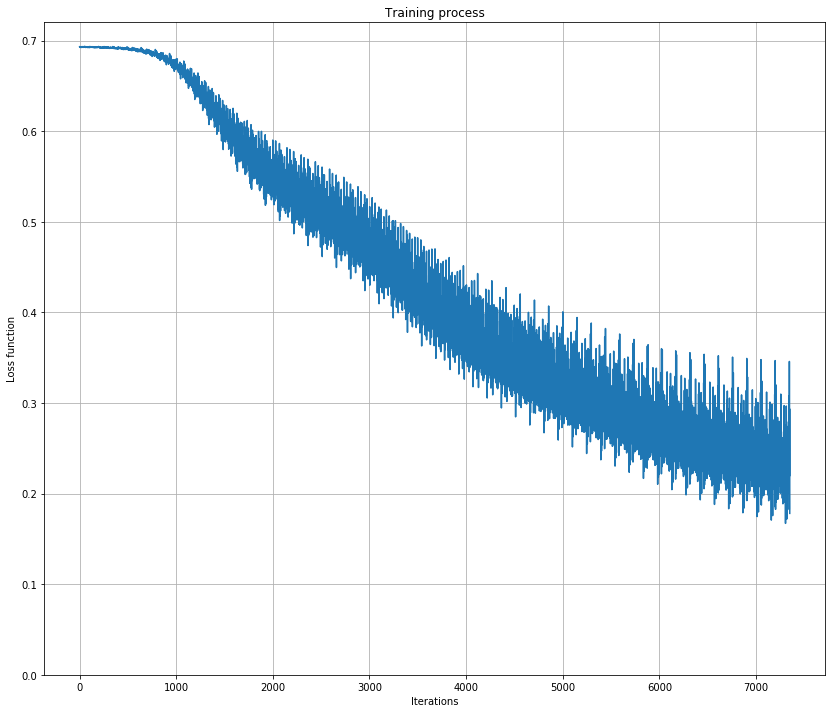

In [22]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.ylim(0);

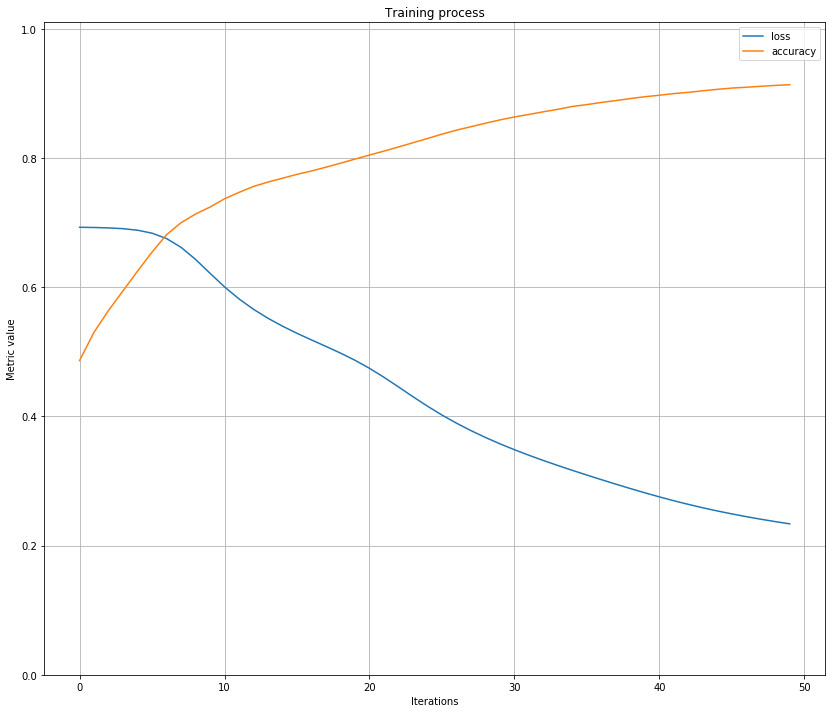

In [23]:
plt.figure(figsize=(14, 12))
plt.plot(loss_per_epoch, label='loss')
plt.plot(metric, label='accuracy')
plt.legend()
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Metric value')
plt.ylim(0, 1.01);

# Test

In [24]:
epoch_losses = []
epoch_predictions = []
epoch_targets = []

for n_batch in range(np.ceil(x_train.shape[0] / batch_size).astype(int)):

    # семплирование батча данных
    x_batch = x_train[n_batch * batch_size:(n_batch + 1) * batch_size]
    y_batch = y_train[n_batch * batch_size:(n_batch + 1) * batch_size]

    # forward
    z1 = np.dot(x_batch, w1) + b1 # линейное преобразование
    a1 = np.maximum(0, z1) # relu
    z2 = np.dot(a1, w2) + b2 # линейное преобразование
    y_hat = 1 / (1 + np.exp(-z2)) # сигмоида
    
    loss = (-(y_batch * np.log(y_hat) + (1 - y_batch) * np.log(1 - y_hat)))
    epoch_losses.append(loss.squeeze())

    epoch_predictions.append(y_hat.squeeze())
    epoch_targets.append(y_batch.squeeze())
    
epoch_predictions = np.concatenate(epoch_predictions)
epoch_targets = np.concatenate(epoch_targets)

epoch_predictions[epoch_predictions >= 0.5] = 1
epoch_predictions[epoch_predictions < 0.5] = 0

epoch_losses = np.concatenate(epoch_losses).mean()

f'Test loss: {epoch_losses:.3f} | accuracy: {accuracy_score(epoch_targets, epoch_predictions):.2f}'

'Test loss: 0.232 | accuracy: 0.91'

# Будем по кускам переделывать на торч

```python
for n_batch in range(np.ceil(x_train.shape[0] / batch_size).astype(int)):

    # семплирование батча данных
    x_batch = x_train[n_batch * batch_size:(n_batch + 1) * batch_size]
    y_batch = y_train[n_batch * batch_size:(n_batch + 1) * batch_size]
```
## Нам нужна батчеварка

In [25]:
from torch.utils.data import Dataset, DataLoader

In [26]:
class SomeData(Dataset):
    
    def __init__(self, x, y):
        
        self.x = x
        self.y = y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.x)
    
    def __getitem__(self, item):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = torch.Tensor(self.x[item])
        y = self.y[item]
        
        return x, y

In [27]:
# обернем данные в класс
train = SomeData(x_train, y_train)

In [28]:
# можем обращаться по индексу
some_x, some_y = train[5]

In [29]:
some_x, some_x.shape

(tensor([ 0.2802, -0.7640,  2.4842, -0.9065,  0.8848, -0.1494, -0.6384,  1.0289,
          2.7441, -1.2015, -0.4553,  1.3574,  0.0407, -2.1166, -1.3768, -1.5576,
          0.0892, -0.3610, -1.4251, -0.7120, -1.5909,  2.1430,  0.6300,  0.5041,
         -1.3812,  0.9790,  0.5778,  5.9497,  2.3687, -0.5152, -1.0131, -1.1878,
          2.0518,  0.5226,  0.1528,  0.1141,  0.7585,  0.7520, -0.8421, -0.3026,
          0.0829, -1.2968,  0.1527, -1.1566, -0.3502,  0.3592, -1.2467,  0.4581,
          1.5836,  0.0674]), torch.Size([50]))

In [30]:
some_y, some_y.shape

(array([0]), (1,))

In [31]:
# дальше оборачиваем в loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [32]:
# и можем по нему итерироваться
for x, y in train_loader:
    break

In [33]:
for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить
        # пока только пройдемся батчами по нашим данным с помощью итератора
        
        time.sleep(0.0001)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.x.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета
Эпоха - 4, прошли - 100.00 % датасета
Эпоха - 5, прошли - 100.00 % датасета
Эпоха - 6, прошли - 100.00 % датасета
Эпоха - 7, прошли - 100.00 % датасета
Эпоха - 8, прошли - 100.00 % датасета
Эпоха - 9, прошли - 100.00 % датасета
Эпоха - 10, прошли - 100.00 % датасета
Эпоха - 11, прошли - 100.00 % датасета
Эпоха - 12, прошли - 100.00 % датасета
Эпоха - 13, прошли - 100.00 % датасета
Эпоха - 14, прошли - 100.00 % датасета
Эпоха - 15, прошли - 100.00 % датасета
Эпоха - 16, прошли - 100.00 % датасета
Эпоха - 17, прошли - 100.00 % датасета
Эпоха - 18, прошли - 100.00 % датасета
Эпоха - 19, прошли - 100.00 % датасета
Эпоха - 20, прошли - 100.00 % датасета
Эпоха - 21, прошли - 100.00 % датасета
Эпоха - 22, прошли - 100.00 % датасета
Эпоха - 23, прошли - 100.00 % датасета
Эпоха - 24, прошли - 100.00 % датасета
Эпоха - 25, прошли - 100.00 % датасета
Эпоха - 26, прошли - 100.00 % дата

In [34]:
x.shape, y.shape

(torch.Size([124, 50]), torch.Size([124, 1]))

## Заменили
```python
for n_batch in range(np.ceil(x_train.shape[0] / batch_size).astype(int)):

    # семплирование батча данных
    x_batch = x_train[n_batch * batch_size:(n_batch + 1) * batch_size]
    y_batch = y_train[n_batch * batch_size:(n_batch + 1) * batch_size]
```
## На
```python
for x, y in train_loader:
```

### У нас может быть какая-то обработка наших примеров, которую мы можем реализовать в __getitem__

In [35]:
class NonLinearDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return x ** n
    
    @staticmethod
    def add_exp_features(x):
        
        return np.exp(x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x_2 = self.add_pow_features(x, n=2)
        # и еще возьмем exp фичи
        x_exp = self.add_exp_features(x)
        
        x = np.concatenate([x, x_2, x_exp])
        
        y = self.data_y[idx]
        
        return x, y

In [36]:
# обернем данные в класс
train = NonLinearDataset(x_train, y_train)
# дальше оборачиваем в loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [37]:
for x, y in train_loader:
    break

In [38]:
x.shape

torch.Size([256, 150])

## Вариаций предобработки масса
### В данном случае будем использовать просто преобразование типов

In [39]:
class ClassificationDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
    
        # приведем к нужному типу
        x = torch.Tensor(x).float()
        
        y = self.data_y[idx].astype('float32')
        
        return x, y

In [40]:
# обернем данные в класс
train = ClassificationDataset(x_train, y_train)
# дальше оборачиваем в loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

# обернем данные в класс
test = ClassificationDataset(x_test, y_test)
# дальше оборачиваем в loader
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [41]:
for x, y in train_loader:
    break

In [42]:
x

tensor([[ 0.2042, -1.3894,  2.3332,  ...,  0.4687, -2.3906,  0.6827],
        [-1.9923, -1.2467,  0.1783,  ...,  1.2094,  0.4250, -0.6950],
        [ 0.5309,  0.2926, -1.6297,  ..., -0.8594, -0.7682,  1.0897],
        ...,
        [ 1.2390,  1.3407, -0.3230,  ..., -0.0034, -0.7406,  0.9761],
        [ 0.3938, -0.0661,  0.0197,  ..., -1.7244, -0.5453,  0.3058],
        [-2.3751, -1.2774, -2.5872,  ...,  0.4808, -0.4227,  1.9251]])

In [43]:
y.dtype

torch.float32

# Перепишем остальную часть тренировки на торч

### Было
```python
w1 = np.random.rand(50, 32) * 0.01
b1 = np.zeros(32)

w2 = np.random.rand(32, 1) * 0.01
b2 = np.zeros(1)
```

### Стало
```python
w1 = torch.rand(50, 32) * 0.01
b1 = torch.zeros(32)

w2 = torch.rand(32, 1) * 0.01
b2 = torch.zeros(1)
```

### Было
```python
z1 = np.dot(x_batch, w1) + b1 # линейное преобразование
a1 = np.maximum(0, z1) # relu
z2 = np.dot(a1, w2) + b2 # линейное преобразование
y_hat = 1 / (1 + np.exp(-z2)) # сигмоида
```

### Стало
```python
z1 = torch.matmul(x_batch, w1) + b1 # линейное преобразование
a1 = torch.relu(z1) # relu
z2 = torch.matmul(a1, w2) + b2 # линейное преобразование
y_hat = torch.sigmoid(z2) # сигмоида
```

### Было
```python
loss = (-(y_batch * np.log(y_hat) + (1 - y_batch) * np.log(1 - y_hat))).mean()
```

### Стало
```python
loss = (-(y_batch * torch.log(y_hat) + (1 - y_batch) * torch.log(1 - y_hat))).mean()
```

### Было
```python
np.dot(x, y)
```

### Стало
```python
torch.matmul(x, y)
```

### Было (транспонирование)
```python
w1.T
```

### Стало (транспонирование)
```python
w1.t()
```

### Было
```python
(a1 > 0)
```

### Стало (просто подправили тип)
```python
(a1 > 0).float()
```

In [44]:
w1 = torch.rand(50, 32) * 0.01
b1 = torch.zeros(32)

w2 = torch.rand(32, 1) * 0.01
b2 = torch.zeros(1)

loss_per_epoch = []
losses = []
metric = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    epoch_losses = []
    epoch_predictions = []
    epoch_targets = []

    for x_batch, y_batch in train_loader:

        # forward
        z1 = torch.matmul(x_batch, w1) + b1 # линейное преобразование
        a1 = torch.relu(z1) # relu
        z2 = torch.matmul(a1, w2) + b2 # линейное преобразование
        y_hat = torch.sigmoid(z2) # сигмоида
        
        epoch_predictions.append(y_hat.squeeze())
        epoch_targets.append(y_batch.squeeze())

        # рассчет bce
        loss = (-(y_batch * torch.log(y_hat) + (1 - y_batch) * torch.log(1 - y_hat))).mean()
        epoch_losses.append(loss)

        #backward
        dLdy_hat = ((y_hat - y_batch) / (y_hat - y_hat ** 2)) / y_hat.shape[0]

        dLdz2 = y_hat * (1 - y_hat) * dLdy_hat

        dLda1 = torch.matmul(dLdz2, w2.t())
        dLdw2 = torch.matmul(a1.t(), dLdz2)
        dLdb2 = dLdz2.sum(0)

        dLdz1 = (a1 > 0).float() * dLda1

        dLdw1 = torch.matmul(x_batch.t(), dLdz1)
        dLdb1 = dLdz1.sum(0)

        # gradient descent
        w2 = w2 - learning_rate * dLdw2
        b2 = b2 - learning_rate * dLdb2

        w1 = w1 - learning_rate * dLdw1
        b1 = b1 - learning_rate * dLdb1
        
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_targets = np.concatenate(epoch_targets)
        
    epoch_predictions[epoch_predictions >= 0.5] = 1
    epoch_predictions[epoch_predictions < 0.5] = 0
    
    metric.append(accuracy_score(epoch_targets, epoch_predictions))
    
    losses.extend(epoch_losses)
    loss_per_epoch.append(np.mean(epoch_losses))

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


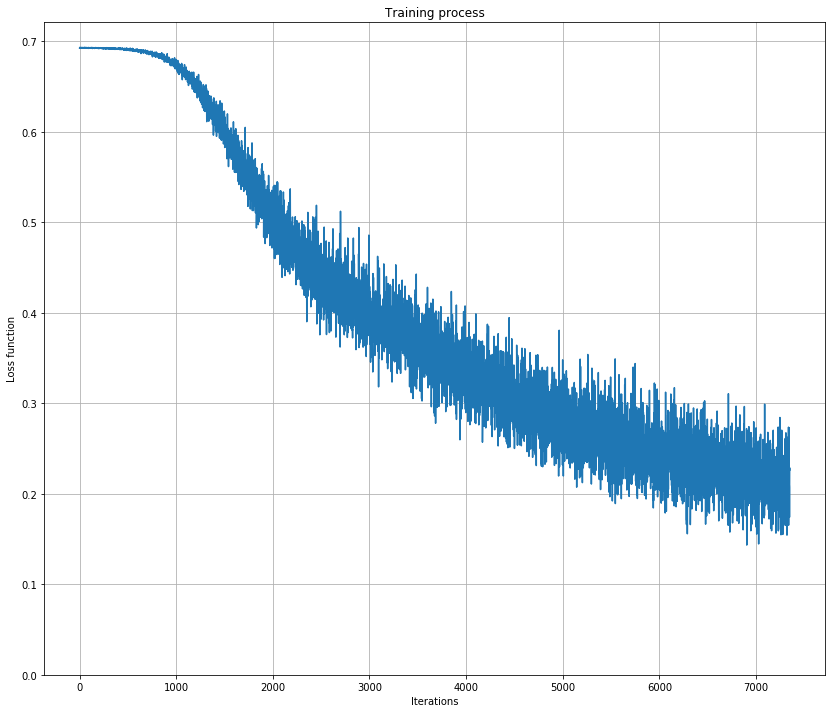

In [45]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.ylim(0);

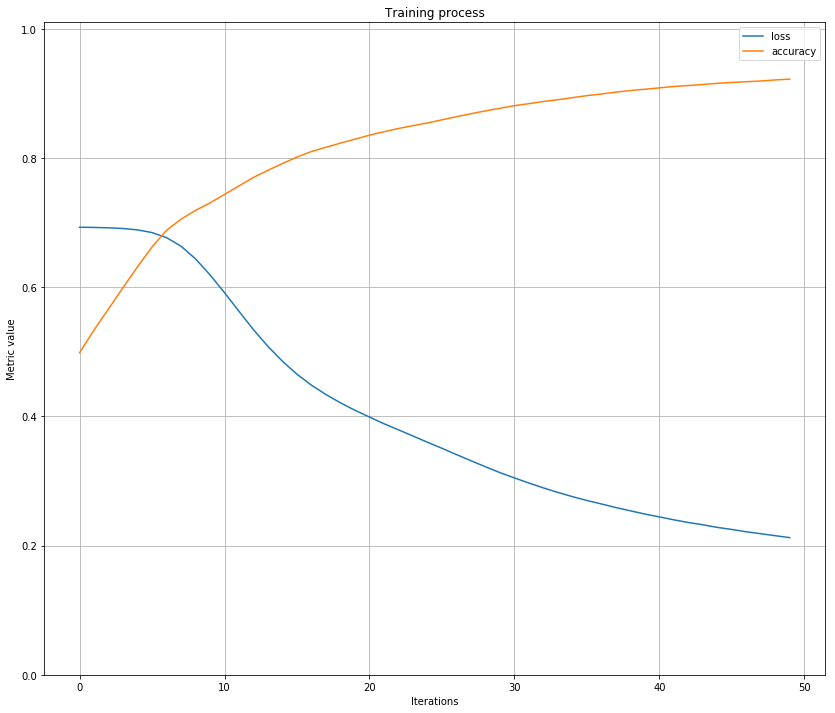

In [46]:
plt.figure(figsize=(14, 12))
plt.plot(loss_per_epoch, label='loss')
plt.plot(metric, label='accuracy')
plt.legend()
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Metric value')
plt.ylim(0, 1.01);

# Автодифференцирование

In [47]:
batch_size = 32
n_features = 300
result_vector = 64

x = torch.rand(batch_size, n_features)
w = torch.rand(n_features, result_vector) * 0.01

y = torch.rand(batch_size, result_vector)

In [48]:
prediction = torch.matmul(x, w)
prediction

tensor([[0.7248, 0.7261, 0.7532,  ..., 0.7393, 0.7272, 0.7147],
        [0.8129, 0.7901, 0.8107,  ..., 0.7935, 0.8030, 0.7544],
        [0.7751, 0.7800, 0.7603,  ..., 0.7471, 0.7880, 0.7268],
        ...,
        [0.7701, 0.7571, 0.7502,  ..., 0.7444, 0.7603, 0.7145],
        [0.7294, 0.7374, 0.7272,  ..., 0.7339, 0.7111, 0.6743],
        [0.7877, 0.7789, 0.7973,  ..., 0.8026, 0.7442, 0.7511]])

In [49]:
mse = ((y - prediction)**2).mean()
mse

tensor(0.1522)

## Теперь зададим параметры и скажем, что по ним нужно считать градиенты

In [50]:
x = torch.rand(batch_size, n_features)
w = torch.rand(n_features, result_vector) * 0.01
# вот эта строчка
w = w.requires_grad_(True)

# аналогично 
# w = torch.nn.Parameter(torch.rand(n_features, result_vector) * 0.01)

y = torch.rand(batch_size, result_vector)

In [51]:
prediction = torch.matmul(x, w)
prediction

tensor([[0.8090, 0.7474, 0.7731,  ..., 0.7541, 0.7893, 0.7389],
        [0.7675, 0.7162, 0.7206,  ..., 0.7562, 0.7895, 0.7281],
        [0.7083, 0.6613, 0.6922,  ..., 0.6862, 0.7053, 0.6996],
        ...,
        [0.7746, 0.7160, 0.7644,  ..., 0.7181, 0.7750, 0.7314],
        [0.8161, 0.7657, 0.7881,  ..., 0.7669, 0.8051, 0.7620],
        [0.7340, 0.7030, 0.6688,  ..., 0.7120, 0.7418, 0.7258]],
       grad_fn=<MmBackward>)

In [52]:
mse = ((y - prediction)**2).mean()
mse

tensor(0.1552, grad_fn=<MeanBackward1>)

### Можно заметить, что у тензоров prediction и mse теперь есть атрибут grad_fn
Это функция, по которой нужно рассчитывать градиент  
И это говорит о том, что теперь у нас есть граф вычислений  
То есть торч сам понимает какой путь ему нужно проделать, чтобы рассчитать градиенты

### Сейчас градиент w просто None

In [53]:
print(w.grad)

None


### Сделаем backward по нашему лоссу
То есть пройдемся по всему построенному графу и посчитаем градиенты

In [54]:
mse.backward()

### Теперь для наших весов появился градиент

In [55]:
w.grad

tensor([[0.0045, 0.0031, 0.0038,  ..., 0.0042, 0.0058, 0.0030],
        [0.0049, 0.0036, 0.0027,  ..., 0.0029, 0.0044, 0.0027],
        [0.0045, 0.0029, 0.0038,  ..., 0.0043, 0.0058, 0.0030],
        ...,
        [0.0044, 0.0028, 0.0036,  ..., 0.0043, 0.0048, 0.0027],
        [0.0057, 0.0040, 0.0031,  ..., 0.0034, 0.0051, 0.0037],
        [0.0058, 0.0036, 0.0036,  ..., 0.0047, 0.0055, 0.0029]])

In [56]:
w.grad.shape, w.shape

(torch.Size([300, 64]), torch.Size([300, 64]))

### Соответственно в нодах графа, где нет обучаемых параметров, мы не считаем градиент

In [57]:
print(prediction.grad), print(x.grad)

None
None


(None, None)

## То есть теперь на не нужно самостоятельно считать backward

### Было
```python
# рассчет bce
loss = (-(y_batch * torch.log(y_hat) + (1 - y_batch) * torch.log(1 - y_hat))).mean()
epoch_losses.append(loss)

#backward
dLdy_hat = ((y_hat - y_batch) / (y_hat - y_hat ** 2)) / y_hat.shape[0]

dLdz2 = y_hat * (1 - y_hat) * dLdy_hat

dLda1 = torch.matmul(dLdz2, w2.t())
dLdw2 = torch.matmul(a1.t(), dLdz2)
dLdb2 = dLdz2.sum(0)

dLdz1 = (a1 > 0).float() * dLda1

dLdw1 = torch.matmul(x_batch.t(), dLdz1)
dLdb1 = dLdz1.sum(0)
```

### Стало
```python
# рассчет bce
loss = (-(y_batch * torch.log(y_hat) + (1 - y_batch) * torch.log(1 - y_hat))).mean()

# также мы отсоединяем значение нашего лосса от графа, чтобы сохранить
epoch_losses.append(loss.item())

#backward
loss.backward()
```
### Было
```python
epoch_predictions.append(y_hat.squeeze())
epoch_targets.append(y_batch.squeeze())
```

### Стало
```python
# также отсоединяем наши предикты и таргеты от графа, чтобы смогли их сохранить
epoch_predictions.append(y_hat.detach().numpy().squeeze())
epoch_targets.append(y_batch.detach().numpy().squeeze())
```

## При условии

### Было
```python
w1 = torch.rand(50, 32) * 0.01
b1 = torch.zeros(32)

w2 = torch.rand(32, 1) * 0.01
b2 = torch.zeros(1)
```

### Стало
```python
w1 = torch.rand(50, 32) * 0.01
w1 = w1.requires_grad_(True)
b1 = torch.zeros(32, requires_grad=True)

w2 = torch.rand(32, 1) * 0.01
w2 = w1.requires_grad_(True)
b2 = torch.zeros(1, requires_grad=True)
```

## Обратите внимание, что градиентный спуск тоже поменялся

### Было
```python
w2 = w2 - learning_rate * dLdw2
b2 = b2 - learning_rate * dLdb2

w1 = w1 - learning_rate * dLdw1
b1 = b1 - learning_rate * dLdb1
```

### Стало
```python
w2.data -= learning_rate * w2.grad.data
b2.data -= learning_rate * b2.grad.data

w1.data -= learning_rate * w1.grad.data
b1.data -= learning_rate * b1.grad.data

w2.grad.data.zero_()
b2.grad.data.zero_()

w1.grad.data.zero_()
b1.grad.data.zero_()
```

In [58]:
w1 = torch.rand(50, 32) * 0.01
w1 = w1.requires_grad_(True)
b1 = torch.zeros(32, requires_grad=True)

w2 = torch.rand(32, 1) * 0.01
w2 = w2.requires_grad_(True)
b2 = torch.zeros(1, requires_grad=True)

loss_per_epoch = []
losses = []
metric = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    epoch_losses = []
    epoch_predictions = []
    epoch_targets = []

    for x_batch, y_batch in train_loader:

        # forward
        z1 = torch.matmul(x_batch, w1) + b1 # линейное преобразование
        a1 = torch.relu(z1) # relu
        z2 = torch.matmul(a1, w2) + b2 # линейное преобразование
        y_hat = torch.sigmoid(z2) # сигмоида
        
        epoch_predictions.append(y_hat.detach().numpy().squeeze())
        epoch_targets.append(y_batch.detach().numpy().squeeze())

        # рассчет bce
        loss = (-(y_batch * torch.log(y_hat) + (1 - y_batch) * torch.log(1 - y_hat))).mean()
        epoch_losses.append(loss.item())

        #backward
        loss.backward()
        
        # gradient descent
        w2.data -= learning_rate * w2.grad.data
        b2.data -= learning_rate * b2.grad.data

        w1.data -= learning_rate * w1.grad.data
        b1.data -= learning_rate * b1.grad.data
        
        w2.grad.data.zero_()
        b2.grad.data.zero_()
        
        w1.grad.data.zero_()
        b1.grad.data.zero_()
        
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_targets = np.concatenate(epoch_targets)
        
    epoch_predictions[epoch_predictions >= 0.5] = 1
    epoch_predictions[epoch_predictions < 0.5] = 0
    
    metric.append(accuracy_score(epoch_targets, epoch_predictions))
    
    losses.extend(epoch_losses)
    loss_per_epoch.append(np.mean(epoch_losses))

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


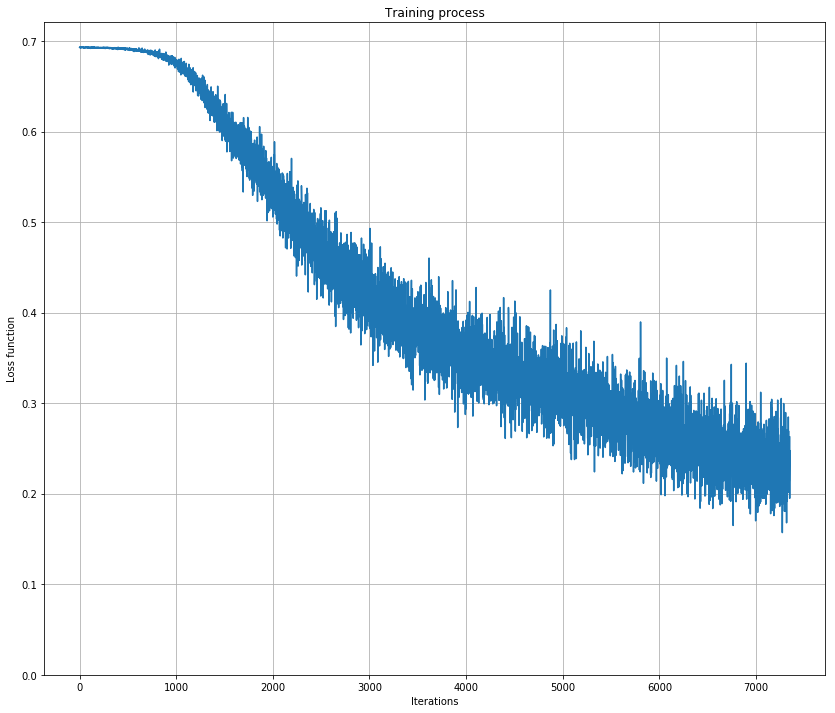

In [59]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.ylim(0);

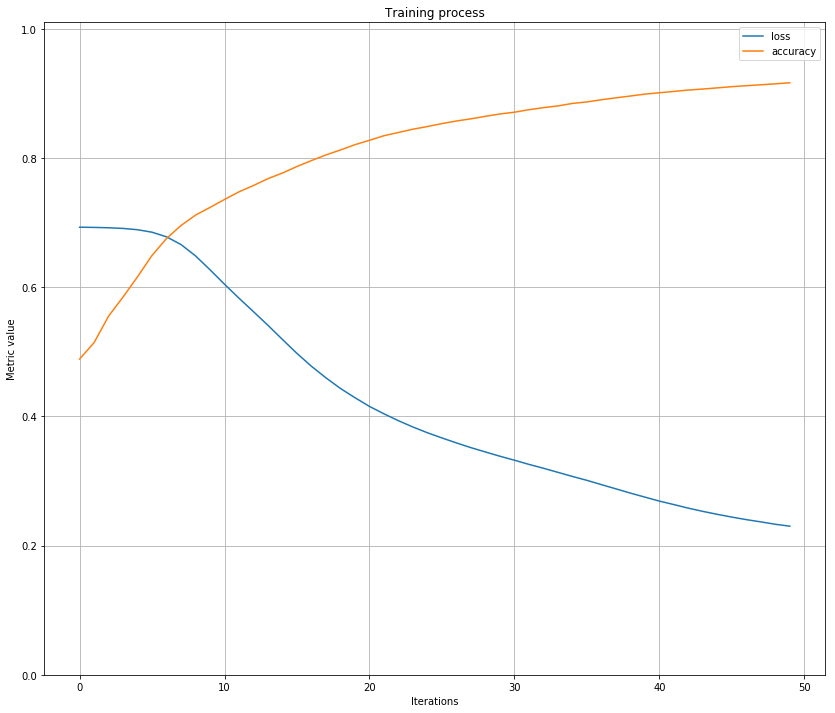

In [60]:
plt.figure(figsize=(14, 12))
plt.plot(loss_per_epoch, label='loss')
plt.plot(metric, label='accuracy')
plt.legend()
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Metric value')
plt.ylim(0, 1.01);

# Как делать правильно
## Высокоуровневое API

In [61]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, n_classes):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        # также нам необходимо обернуть внутри класса модели наши веса в torch.nn.Parameter
        # https://pytorch.org/docs/stable/nn.html#torch.nn.Parameter
        self.w1 = torch.nn.Parameter(torch.rand(in_features, inner_features) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(inner_features))

        self.w2 = torch.nn.Parameter(torch.rand(inner_features, n_classes) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(n_classes))
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # то как нужно преобразовать входные данные через сеть
        z1 = torch.matmul(x, self.w1) + self.b1 # линейное преобразование
        a1 = torch.relu(z1) # relu
        z2 = torch.matmul(a1, self.w2) + self.b2 # линейное преобразование
        y_hat = torch.sigmoid(z2) # сигмоида
        
        return y_hat
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [62]:
# определяем нашу модель
model = MLP(in_features=50, inner_features=32, n_classes=1)

In [63]:
model

MLP()

In [64]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [65]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [66]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[6.7504e-03, 1.3991e-03, 3.1453e-03,  ..., 7.0840e-03, 2.4035e-03,
          2.0422e-03],
         [9.4674e-03, 9.8483e-03, 8.3862e-03,  ..., 6.3987e-03, 8.0000e-03,
          8.9883e-03],
         [1.9971e-03, 8.6127e-03, 3.3653e-05,  ..., 4.1129e-03, 8.1401e-03,
          4.8137e-03],
         ...,
         [3.1991e-03, 6.9265e-03, 3.5834e-03,  ..., 2.4318e-03, 3.9026e-03,
          5.6426e-03],
         [4.2766e-03, 2.8868e-03, 3.7157e-03,  ..., 6.2249e-05, 6.5028e-03,
          7.9809e-03],
         [7.6363e-03, 4.5356e-03, 4.9299e-03,  ..., 1.5853e-03, 4.1296e-03,
          1.4176e-03]], requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
 tensor([[0.0022],
         [0.0077],
         [0.0051],
         [0.0038],
         [0.0040],
         [0.0035],
         [0.0024],
  

In [67]:
loss_per_epoch = []
losses = []
metric = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    epoch_losses = []
    epoch_predictions = []
    epoch_targets = []

    # эта штука все еще отдает нам батчи данных
    for x, y in train_loader:

        # обновим наши градиенты
        # будем делать это каждую итерацию обучения
        # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
        # 
        # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
        # функция сохранения градиентов нужна для аккамуляции градиентов
        # например, когда нам не хватает памяти на большой батч
        # мы можем несколько раз прогнать forward на разных батчах
        # наши градиенты будут сохраняться
        # и только потом через несколько итераций forward обновить наши веса
        # таким образом у нас получается больше батч
        # 
        optimizer.zero_grad()

        # 
        # предсказание нашей модели
        # здесь торч сам сохраняет необходимую информацию
        # 
        # торч строит граф вычислений
        # то есть строит граф по тем операциям, которые вы определили в методе forward
        # 
        # то есть торч понимает, что вы сначала применили линейное преобразование
        # знает, где лежат веса для этого линейного преобразования
        # знает, что вы затем применили релу
        # затем опять линейное преобразование
        # затем сигмоиду
        # и вот таким образом торч выстроил граф
        # который нужен будет для backpropogation
        # 
        pred = model(x)

        # 
        # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
        # 
        loss = criterion(pred, y)
        
        epoch_predictions.append(pred.detach().numpy().squeeze())
        epoch_targets.append(y.detach().numpy().squeeze())

        # 
        # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
        # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
        # передаем градиенты на следующие узлы
        # для весов сохраняет
        # 
        loss.backward()

        # 
        # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
        # 
        optimizer.step()

        # 
        # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
        # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
        # чтобы граф не строился дальше на каждой итерации обучения
        # работает для скаляров
        # 
        # для тензоров работает метод .tolist()
        # 
        current_loss_value = loss.item()
        epoch_losses.append(loss.item())

    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_targets = np.concatenate(epoch_targets)

    epoch_predictions[epoch_predictions >= 0.5] = 1
    epoch_predictions[epoch_predictions < 0.5] = 0

    metric.append(accuracy_score(epoch_targets, epoch_predictions))

    losses.extend(epoch_losses)
    loss_per_epoch.append(np.mean(epoch_losses))

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


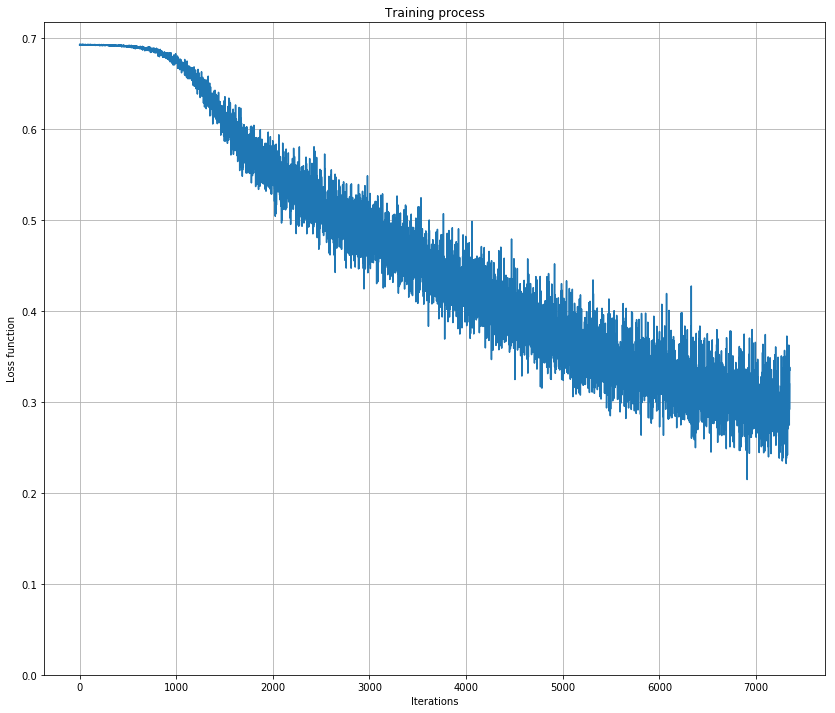

In [85]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.ylim(0);

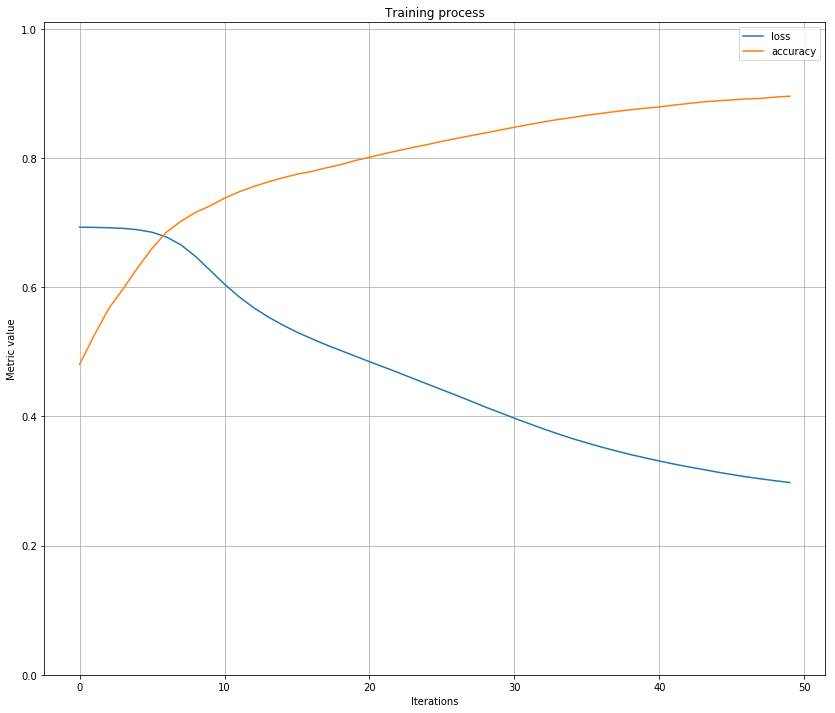

In [69]:
plt.figure(figsize=(14, 12))
plt.plot(loss_per_epoch, label='loss')
plt.plot(metric, label='accuracy')
plt.legend()
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Metric value')
plt.ylim(0, 1.01);

# Test

In [70]:
epoch_losses = []
epoch_predictions = []
epoch_targets = []

for x, y in test_loader:

    with torch.no_grad():
        pred = model(x)
    
    epoch_losses.append(loss.item())

    epoch_predictions.append(pred.detach().numpy().squeeze())
    epoch_targets.append(y.detach().numpy().squeeze())
    
epoch_predictions = np.concatenate(epoch_predictions)
epoch_targets = np.concatenate(epoch_targets)

epoch_predictions[epoch_predictions >= 0.5] = 1
epoch_predictions[epoch_predictions < 0.5] = 0

epoch_losses = np.mean(epoch_losses)

f'Test loss: {epoch_losses:.3f} | accuracy: {accuracy_score(epoch_targets, epoch_predictions):.2f}'

'Test loss: 0.335 | accuracy: 0.90'

# Можем еще более верхнеуровнево записать наш класс

In [71]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, n_classes):
        super().__init__()
        
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=n_classes)
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.sigmoid(x)
        
        return x

# Добавить еще слоев

In [72]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features_1, inner_features_2, n_classes):
        super().__init__()
        
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features_1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.linear_2 = torch.nn.Linear(in_features=inner_features_1, out_features=inner_features_2)
        self.batch_norm = torch.nn.BatchNorm1d(num_features=inner_features_2)
        self.linear_3 = torch.nn.Linear(in_features=inner_features_2, out_features=n_classes)
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.batch_norm(x)
        x = self.linear_3(x)
        x = torch.sigmoid(x)
        
        return x

# Можно использовать в качестве слоев свои написанные классы

In [73]:
class GatedLinearUnit(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.linear = torch.nn.Linear(in_features=in_features, out_features=out_features)
        self.gate = torch.nn.Linear(in_features=in_features, out_features=out_features)
        
    def forward(self, x):
        
        x = self.linear(x) * torch.sigmoid(torch.gate(x)) + x
        
        return x

In [74]:
class SomeNeuralNetwork(torch.nn.Module):
    
    def __init__(self, in_features, inner_features_1, inner_features_2, n_classes):
        super().__init__()
        
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features_1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.glu = GatedLinearUnit(in_features=inner_features_1, out_features=inner_features_2)
        self.batch_norm = torch.nn.BatchNorm1d(num_features=inner_features_2)
        self.linear_3 = torch.nn.Linear(in_features=inner_features_2, out_features=n_classes)
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.glu(x)
        x = self.batch_norm(x)
        x = self.linear_3(x)
        x = torch.sigmoid(x)
        
        return x

In [75]:
model = SomeNeuralNetwork(in_features=256, inner_features_1=128, inner_features_2=64, n_classes=4)

In [76]:
model

SomeNeuralNetwork(
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5)
  (glu): GatedLinearUnit(
    (linear): Linear(in_features=128, out_features=64, bias=True)
    (gate): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=64, out_features=4, bias=True)
)

# MNIST

In [77]:
import numpy as np

from sklearn.metrics import classification_report

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm

# Немного магических нормализаций для картинок

In [78]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [79]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [80]:
x, y = train_dataset[0]
x.shape

torch.Size([1, 28, 28])

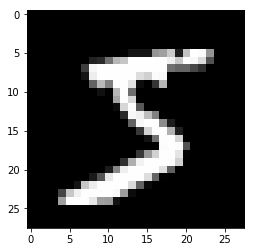

In [81]:
plt.imshow(x.squeeze(), cmap=plt.cm.Greys_r)

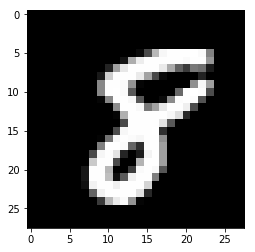

In [82]:
x, y = train_dataset[777]
plt.imshow(x.squeeze(), cmap=plt.cm.Greys_r)

In [83]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

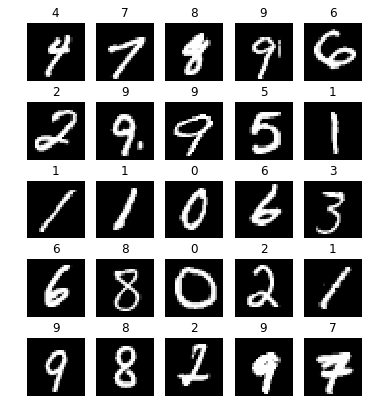

In [84]:
for x, y in train_loader:
    break

x = x.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[i].squeeze(), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## В качестве упражнения попробуйте самостоятельно сделать классификатор на торче
[Поможет](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)